# Example Spatial Target Cells Visualization

This notebook contains plots of example cells from the spatial target analysis. 

In [1]:
%config Completer.use_jedi = False

In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt

from convnwb.io import load_nwbfile
from convnwb.io import get_files, save_json

from spiketools.measures.trials import compute_segment_frs
from spiketools.measures.measures import compute_firing_rate
from spiketools.measures.conversions import convert_times_to_rates
from spiketools.spatial.occupancy import (compute_bin_counts_assgn, compute_bin_edges, 
                                          compute_bin_assignment, normalize_bin_counts)
from spiketools.spatial.information import compute_spatial_information
from spiketools.spatial.place import compute_occupancy, compute_bin_counts_pos
from spiketools.spatial.utils import compute_nbins, compute_pos_ranges, convert_2dindices
from spiketools.spatial.target import compute_target_bins
from spiketools.stats.shuffle import shuffle_spikes
from spiketools.stats.permutations import compute_surrogate_stats
from spiketools.utils import set_random_seed
from spiketools.utils.base import select_from_list
from spiketools.utils.data import compute_range
from spiketools.utils.extract import (get_range, get_value_by_time, get_values_by_time_range,
                                      get_values_by_times, threshold_spikes_by_times)
from spiketools.utils.epoch import (epoch_data_by_range, epoch_spikes_by_segment, 
                                    epoch_spikes_by_range, epoch_spikes_by_event)

from spiketools.plts.data import plot_bar
from spiketools.plts.spatial import plot_heatmap, plot_positions, create_heat_title
from spiketools.plts.trials import plot_rasters
from spiketools.plts.stats import plot_surrogates
from spiketools.plts.utils import make_axes, save_figure
from spiketools.plts.annotate import color_pval

In [3]:
import sys
sys.path.append('../code')
# from models import * 
from utils import *
from plts import *

In [4]:
import seaborn as sns
sns.set_context('talk')

## Settings

In [5]:
# Define the base data folder
data_folder = '/Users/Claire_han/Documents/Data/JacobsLab/TH/NWB'

In [6]:
# Define session information
session = {
    'experiment' : 'THO',
    'subject' : 'wv001',
    'session' : 2
}

In [7]:
# Set which example unit to extract
uind = 0

In [8]:
# Define binning for chests (spatial target)
chest_bins = [3, 5]
bins = [5, 7]

n_bins = compute_nbins(chest_bins)

In [9]:
# Shuffle Settings
shuffle_approach = 'CIRCULAR'  # 'CIRCULAR', 'BINCIRC'
n_surrogates = 500

if shuffle_approach == 'CIRCULAR':
    shuffle_kwargs = {}
    #shuffle_kwargs = {'shuffle_min' : 20000}
if shuffle_approach == 'BINCIRC':
    shuffle_kwargs = {}

In [10]:
# Set which analysis method to run
METHOD = 'INFO'  # 'INFO' / 'ANOVA'

In [11]:
# Define occupancy settings: minimum required occupancy (in seconds) & speed threshold
min_occ = 1
speed_thresh = 5e-6
time_thresh = 0.25

## Load data

In [12]:
# Get the list of NWB files
nwbfiles = get_files(data_folder)

In [13]:
# Load example NWB file
nwbfile = load_nwbfile(session, data_folder)

### Get trial data

In [14]:
# Get the number of trials
n_trials = len(nwbfile.trials)
print('Number of trials: {}'.format(n_trials))

Number of trials: 24


In [15]:
nav_starts = nwbfile.trials.navigation_start[:]
nav_stops = nwbfile.trials.navigation_stop[:]
chest_openings = nwbfile.trials['chest_opening_time'][:]
ch_openings_all = np.array(chest_openings).reshape(-1,1)

### Get spike data

In [16]:
# Check the number of units & keep indices
n_units = len(nwbfile.units)
keep_inds = np.where(nwbfile.units.keep[:])[0]
n_keep = len(keep_inds)
print('Number of units: {}'.format(n_units))
print('Number to keep:  {}'.format(n_keep))

Number of units: 118
Number to keep:  85


In [17]:
# Get spikes
spikes = nwbfile.units.get_unit_spike_times(uind)

### Get position data

In [18]:
# Get area ranges, adding a buffer to the z-range (for tower transport)
area_range = [nwbfile.acquisition['boundaries']['x_range'].data[:],
              nwbfile.acquisition['boundaries']['z_range'].data[:] + np.array([-15, 15])]
area_range = [[area_range[0][0], area_range[0][1]], [area_range[1][0], area_range[1][1]]]

In [19]:
# Get position & speed information
positions = nwbfile.acquisition['position']['player_position'].data[:].T
ptimes = nwbfile.acquisition['position']['player_position'].timestamps[:]
stimes = nwbfile.processing['position_measures']['speed'].timestamps[:]
speed = nwbfile.processing['position_measures']['speed'].data[:]

In [20]:
# Get position data for navigation segments
ptimes_trials, positions_trials = epoch_data_by_range(ptimes, positions, nav_starts, nav_stops)
stimes_trials, speed_trials = epoch_data_by_range(stimes, speed, nav_starts, nav_stops)

# Recombine position data across selected navigation trials
ptimes = np.hstack(ptimes_trials)
positions = np.hstack(positions_trials)
stimes = np.hstack(stimes_trials)
speed = np.hstack(speed_trials)

spike_positions = get_values_by_times(ptimes, positions, spikes, threshold=0.1)

## Chest position

In [21]:
# Define the area range for chest appearance 
area_range_chest = [[360, 410], [320, 400]]

# Get chest positions
chest_xs, chest_ys = nwbfile.acquisition['stimuli']['chest_positions'].data[:].T
chest_trials = nwbfile.trials.chest_trials[:]

# Compute edges for chest binning
x_edges, y_edges = compute_bin_edges(positions, chest_bins, area_range=area_range_chest)

# Assign each chest to a bin
chest_pos = np.array([chest_xs, chest_ys])
ch_xbin, ch_ybin = compute_bin_assignment(chest_pos, x_edges, y_edges)

# Compute the 1d equivalent of the 2d indices
chbins = convert_2dindices(ch_xbin, ch_ybin, chest_bins)

In [22]:
# Define the segment times of interest
seg_times = np.insert(np.array(chest_openings), 0, nav_starts, axis=1)
chest_trial_number = np.array(list(range(len(chest_trials)))).reshape(n_trials,4)

In [23]:
# Compute chest occupancy
chest_occupancy = compute_bin_counts_assgn(chest_bins, ch_xbin, ch_ybin)

# Compute the segment firing rate per chest segment, per trial
target_frs = compute_segment_frs(spikes, seg_times)

# Compute the average firing across spatial target bins
target_bins = compute_target_bins(target_frs, chest_bins, ch_xbin, ch_ybin, chest_occupancy)
reshaped_target = reshape_bins(target_bins, bins)

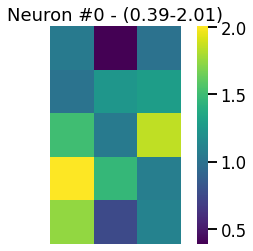

In [24]:
# Check the firing rate per spatial target for an example neuron
plot_heatmap(target_bins, ignore_zero=False, title=create_heat_title('Neuron #{}'.format(uind), 
                                                                    target_bins), cbar=True)

## One example target cell

In [26]:
# Get the spikes, subject path, chest positions for each bin 
chests_per_bin, empty_bins = [], []
chest_x_all, chest_y_all = [], []
tpos_per_bin, tspikes_pos_per_bin = [], []

for ind in range(n_bins):
    
    reshaped_bins = reshape_bins(target_bins, bins)
    bin_pos = list(set(np.where(chbins==ind)[0]))
    chests_per_bin.append(bin_pos)
    
    if bin_pos == []:
        empty_bins.append(ind)
    else: 
        chest_x = [chest_pos[0][i] for i in chests_per_bin[ind]]
        chest_y =[chest_pos[1][i] for i in chests_per_bin[ind]]
        chest_x_all.append(chest_x)
        chest_y_all.append(chest_y)
        tpos_all, tspikes_pos = get_pos_per_bin(chests_per_bin[ind], chest_trial_number, ptimes, 
                                                positions, spikes, nav_starts, ch_openings_all)
        tpos_per_bin.append(tpos_all)
        tspikes_pos_per_bin.append(tspikes_pos)


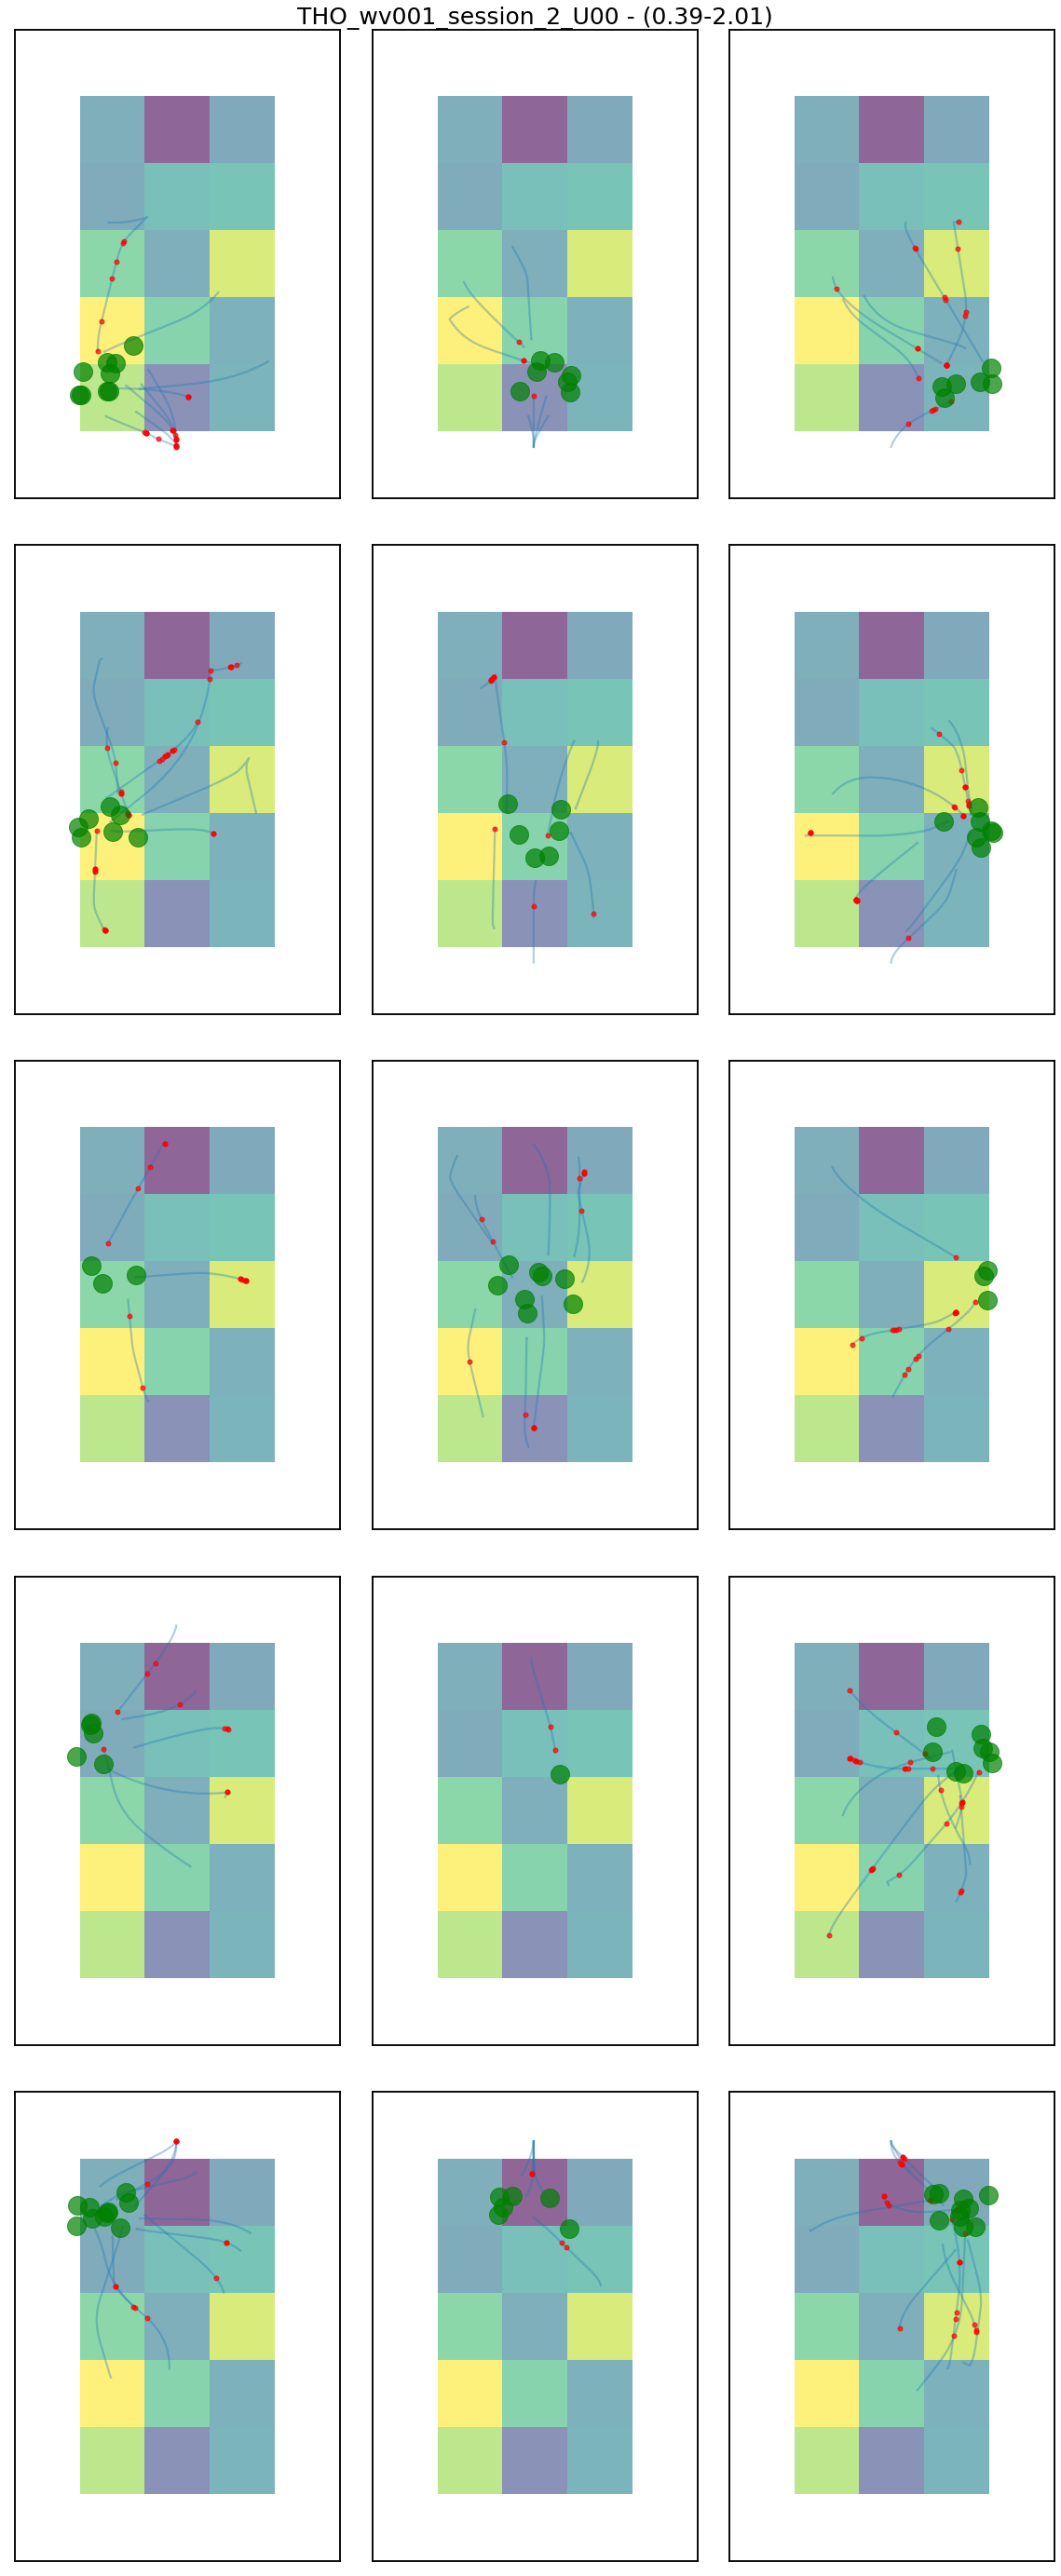

In [27]:
# Plot the subject path, spikes, chest positions per bin for a example spatial target cell
name = nwbfile.session_id + '_U' + str(uind).zfill(2)
plot_example_target(n_bins, target_bins, chests_per_bin, tpos_per_bin, tspikes_pos_per_bin, 
                    chest_x_all, chest_y_all, reshaped_bins, area_range, name)

## All significant target cells